In [1]:
import numpy as np
import pandas as pd
import scipy.integrate as integrate
import scipy.optimize
from sklearn.neighbors import KernelDensity

#from scipy.stats import f as F_distr
#from statsmodels.nonparametric.kernel_regression import KernelReg
#from scipy import stats
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
data_frame_2014=pd.read_csv("dados_tratados/2014/numero_eleitores2014.dat",dtype={"eleitores":np.int32})
data_frame_2010=pd.read_csv("dados_tratados/2010/numero_eleitores2010.dat",dtype={"eleitores":np.int32})
data_frame_2006=pd.read_csv("dados_tratados/2006/numero_eleitores2006.dat",dtype={"eleitores":np.int32})

In [3]:
def calcular_v(votos,dinheiro,delta_m,t,dt,Ne,Nc):
    H=Heavside(t,dinheiro,delta_m,Nc)
    S=sum(votos)
    votos=votos+(1.-S/Ne)*H*dt
    return votos

In [4]:
def Heavside(t,dinheiro,delta_m,Nc):
    H=np.zeros(Nc)
    for i in xrange(Nc):
        t_estrela=dinheiro[i]/delta_m
        if t>t_estrela:
            H[i]=0
        else:
            H[i]=1
    return H

In [5]:
def open_file(name,index1,index2):
    infile=file(name)
    x=[]
    y=[]
    for line in infile:
        data=line.split()
        if float(data[index1])>0. and float(data[index2])>0:  
            x.append(float(data[index1]))
            y.append(float(data[index2]))
    return x,y

In [6]:
def read_eleicao(uf,cargo,ano):    
    #name="krylov/politica/votos_despesas_dep_"+cargo+"/votos_doacao%s.dat"%uf
    name="dados_tratados/2014/votos_despesas_dep_"+cargo+"/votos_doacao%s.dat"%uf

    x,y=open_file(name,index1=1,index2=2)
    y=np.array(y)
    x=np.array(x)
    if ano=="2014": Ne=data_frame_2014[data_frame_2014.estados==uf].eleitores.values[0]
    if ano=="2010": Ne=data_frame_2010[data_frame_2010.estados==uf].eleitores.values[0]
    if ano=="2006": Ne=data_frame_2006[data_frame_2006.estados==uf].eleitores.values[0]
    return x,y,Ne

In [7]:
def integral_cumulativa(dinheiro):
    Nc=len(dinheiro)    
    xx=[x for x in dinheiro]
    xx.sort()
    xx=[0.]+xx
    theta=range(Nc,-1,-1)
    R_estrela = integrate.trapz(theta,xx,dx=m)
    #plt.plot(np.log10(xx),theta)
    return R_estrela,xx,theta

In [8]:
def calculate_fracao_esperada(dinheiro,Ne,delta_m):
    R_estrela=integral_cumulativa(dinheiro)
    print (1.-exp(-R_estrela/(delta_m*Ne)))

In [9]:
def sortear_v0(votos,dinheiro):
    x=votos[dinheiro<10000.]
    Nc=len(votos)
    v0=np.ones(Nc)
    for i in xrange(Nc):
        v0[i]=np.random.choice(x)
    return v0

In [10]:
def binagem(x,y,n_bins):
    x=np.log10(np.array(x))
    #y=np.log10(np.array(y))

    y=np.array(y)
    x_min=min(x)
    x_max=max(x)
    bins=np.linspace(x_min,x_max,n_bins)
    y_media=np.zeros(len(bins)-1)
    y_std=np.zeros(len(bins)-1)
    bins_media=np.zeros(len(bins)-1)
    for i in xrange(len(bins)-1):
        a=y[(x>bins[i])==(x<bins[i+1])]
        y_media[i]=np.mean(a[a>0.])
        y_std[i]=np.std(a[a>0.])
        bins_media[i]=(bins[i]+bins[i+1])/2.
    return bins_media,y_media,y_std

In [11]:
def calcular_serie(dinheiro,v0,Ne,delta_m):
    #v0=100.
    dinheiro=sorted(dinheiro)
    Nc=len(dinheiro)*1.
    v_calc=np.zeros(Nc)
    R=np.sum(dinheiro)
    S0=v0*Nc
    v_calc[0]=v0+((Ne-S0)/Nc)*(1.-np.exp(-Nc*dinheiro[0]/(delta_m*Ne)) )
    for i in xrange(1,int(Nc)):
        Sp=np.sum(dinheiro[:i-1])
        exp_aux=np.exp(-Sp/(delta_m*Ne))
        A=(Ne-S0)/(Nc-i)
        v_calc[i]=v_calc[i-1]-A*exp_aux*(np.exp(-(Nc-i)*dinheiro[i]/(delta_m*Ne))-np.exp(-(Nc-i)*dinheiro[i-1]/(delta_m*Ne)) )
    return dinheiro,v_calc

In [12]:
def colector_curve(n):
    Nc=len(n)
    vec=[]
    for i in xrange(Nc):
        vec=vec+int(n[i])*[i]
    np.random.shuffle(vec)
    not_news=[]
    S=[0]*len(vec)
    for i in xrange(1,len(vec)):
        if vec[i] not in not_news:
            S[i]=S[i-1]+1
            not_news.append(vec[i])
        else:
            S[i]=S[i-1]
    return S
        

In [13]:
def mu_calculo(dinheiro,Nt,delta_m,T,modo):
    dinheiro=dinheiro/delta_m
    #print len(dinheiro),min(dinheiro)
    #dinheiro=dinheiro[dinheiro>1.0]
    #print len(dinheiro),min(dinheiro)
    
    Nc=len(dinheiro)
    lim_max=1000.0
    #if T>0.8: lim_max=-1e-10
    #else: lim_max=10.0
    lim_min=-1000.
    def f_continum(x):
        A=np.sum(dinheiro/(np.exp(x*dinheiro)-1.))
        return Nc/x-A-Nt
    def f_discreto(x):
        B=np.sum((dinheiro+1.)/(np.exp(x*(dinheiro+1.))-1.))
        #B=np.sum((1.+dinheiro)/(1.-np.exp(-x*(dinheiro+1.))))
        return Nc/(1.-np.exp(-x))-B-Nt
    if modo=="discreto":
        #print f_discreto(lim_min),f_discreto(lim_max),lim_min,lim_max
        return scipy.optimize.brentq(f_discreto,lim_min,lim_max)
    if modo=="continum":
        #print f_continum(lim_min),f_continum(lim_max),lim_min,lim_max
        return scipy.optimize.brentq(f_continum,lim_min,lim_max)

In [14]:
def gerar_ruidoso(dinheiro,mu,Ne,T):

    R=np.sum(dinheiro)
    delta_m=T*R/(1.*Ne)
    
    model_noise=np.zeros(len(dinheiro))

    for i in xrange(len(dinheiro)):
        Lambda=votos_MaxEnt[i]
        r=np.random.exponential(Lambda,1)
        #if dinheiro[i]/delta_m<1.0:
        #    r=0
        #else:
        #    Z=np.exp(mu)/(np.exp(mu)-1)-np.exp(-mu*dinheiro[i]/delta_m)/(np.exp(mu)-1)
        #    v_vetor = np.linspace(0, dinheiro[i]/(delta_m), int(dinheiro[i]/(delta_m)))

        #    pdf = np.exp(-mu*v_vetor)/Z
        #    pdf=pdf/np.sum(pdf)
        #    r=np.random.choice(v_vetor,size=1,replace=True,p=pdf)
        if r>=1:
            model_noise[i]=int(r)
        else:
            model_noise[i]=1

    return model_noise

In [15]:
def calcular_usando_integral(dinheiro,votos,Ne,T):

    t_max=10000000
    dt=1
    Nc=len(dinheiro)
    R=np.sum(dinheiro)
    
    if len(votos[dinheiro<1000.])==0: v0=0.0
    else: v0=np.mean(votos[dinheiro<1000.])

    delta_m=T*R/(1.*Ne)
    
    print delta_m,v0,
    #v=[x for x in v0]
    v = np.ones(Nc)*v0
    S0=np.sum(v)
    for t in xrange(t_max):
        v=calcular_v(v,dinheiro,delta_m,t,dt,Ne,Nc)
        S=np.sum(v)
        if np.sum(v)/Ne>0.999: break
        if S==S0: break
        S0=S
        #if t%10000==0: print t,np.sum(v)/Ne
    print S/(1.*Ne),np.sum(votos)/(1.*Ne)
    return v
    
    

In [16]:
def calcular_usando_analitico(dinheiro,votos,Ne,T):
    Nc=len(dinheiro)
    R=np.sum(dinheiro)
    delta_m=T*R/(1.*Ne)
    v0=0.0
    #if len(votos[dinheiro<1000.])==0: v0=0.0
    #else: v0=np.mean(votos[dinheiro<1000.])
    
    return calcular_serie(dinheiro,v0,Ne,delta_m)

In [17]:
def calcular_usando_MaxEnt(dinheiro,votos,Ne,Nt,T,modo):
    Nc=len(dinheiro)
    R=np.sum(dinheiro)
    delta_m=T*R/(1.*Ne)
    mu=mu_calculo(dinheiro,Nt,delta_m,T,modo)
    if modo=="discreto":
        return mu,(1./(1.-np.exp(-mu))) - (1. + dinheiro/delta_m)/(np.exp(mu*(1. + dinheiro/delta_m))-1.)
    #(1./(np.exp(mu)-1.))-(1. + dinheiro/delta_m)/(np.exp(mu*(1. + dinheiro/delta_m)-1.))
    if modo=="continum":
        return mu,1./mu - (dinheiro/delta_m)/(np.exp(mu*dinheiro/delta_m)-1.)




In [18]:
def calcular_kde(data):
    
    
    x = np.linspace(min(data),max(data),100)[:, np.newaxis]

    h=(4.*np.std(data)**5/(3.*len(data)))**(1./5)
    print h,np.std(data),np.mean(data)
    data= np.array(data)[:,np.newaxis]
    kde=KernelDensity(kernel='gaussian', bandwidth=h).fit(data)
    log_dens = kde.score_samples(x)
    #plt.plot(x,np.exp(log_dens))
    return np.linspace(min(data),max(data),100),np.exp(log_dens)

In [20]:
##CALCULO USANDO INTEGRAL///  LENTO #####

d,v,Ne = read_eleicao("CE","federal")

Nt = np.sum(v)
T = -1./(np.log(1.-Nt/Ne))
print Nt/Ne,T
votos_modelo=calcular_usando_integral(d,v,Ne,T)


TypeError: read_eleicao() takes exactly 3 arguments (2 given)

In [22]:
##CALCULO ANALITICO///  FAST #####

d,v,Ne = read_eleicao("SP","estadual")

Nt = np.sum(v)
T = -1./(np.log(1.-Nt/Ne))
print Nt/Ne,T
d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)

0.545725428046 1.26734122048


In [20]:
d,v,Ne = read_eleicao("SP","estadual")
Nt = np.sum(v)
print Nt,
T =0.5#-1./(np.log(1.-Nt/Ne))
#Nt=Ne*(1.-np.exp(-1./T))
#Nt=Nt-len(d)*700
print Nt/Ne,T,Nt,-1./(np.log(1.-Nt/Ne)),"opa"
mu,votos_MaxEnt=calcular_usando_MaxEnt(d,v,Ne,Nt,T,"discreto")
print Nt/np.sum(votos_MaxEnt),mu

17462358.0 0.545725428046 0.5 17462358.0 1.26734122048 opa
1.00000000946 1.26902082429e-05


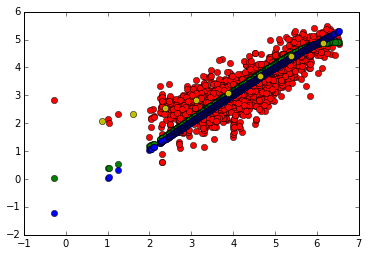

In [24]:
x_mean,y_mean,y_std=binagem(d,v,10)

plt.plot(np.log10(d),np.log10(v),"ro")
#plt.plot(np.log10(d),np.log10(votos_modelo),"ko")
plt.plot(np.log10(d),np.log10(votos_MaxEnt+00),"go")
plt.plot(np.log10(d_sorted),np.log10(votos_modelo_analitico),"bo")
plt.plot(x_mean,np.log10(y_mean),"yo")

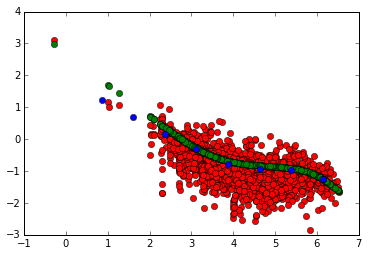

In [187]:
plt.plot(np.log10(d),np.log10(v/d),"ro")
plt.plot(np.log10(d),np.log10((votos_MaxEnt+500)/d),"go")
#plt.plot(np.log10(d_sorted),np.log10(votos_modelo_analitico/d_sorted),"bo")
plt.plot(x_mean,np.log10(y_mean/10**x_mean),"bo")

1.26902082429e-05


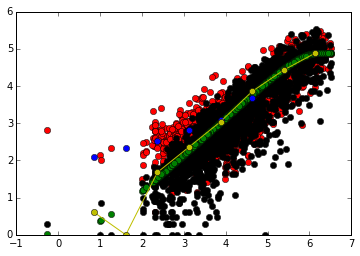

In [36]:
print mu
v_ruidoso=gerar_ruidoso(d,mu,Ne,T)
plt.plot(np.log10(d),np.log10(v),"ro")
plt.plot(np.log10(d),np.log10(v_ruidoso),"ko")
plt.plot(np.log10(d),np.log10((votos_MaxEnt)),"go")
x_mean,y_mean,y_std=binagem(d,v,10)
plt.plot(x_mean,np.log10(y_mean),"bo")
x_mean,y_mean_ruido,y_std=binagem(d,v_ruidoso,10)
plt.plot(x_mean,np.log10(y_mean_ruido),"yo-")

#plt.plot(np.log10(d),np.log10(d/(T*np.sum(d)/Ne)),"-")


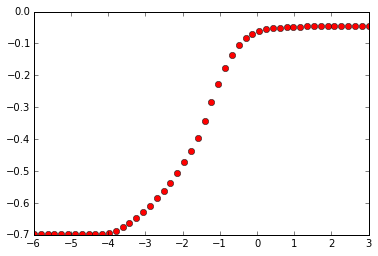

In [119]:
Nc=1000
Ne=1e6
d = 10**np.linspace(1,5,Nc)
v = [x for x in d]

T_vec = 10**np.linspace(-6.,3,50)

v_max_Anal=[]

for T in T_vec:
    d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)
    v_max_Anal.append(np.max(votos_modelo_analitico)/np.sum(votos_modelo_analitico))

#plt.plot(np.log10(T_vec),np.log10(v_max_Anal),"bo")

Nc=5
Ne=1e6
d = 10**np.linspace(1,5,Nc)
v = [x for x in d]

T_vec = 10**np.linspace(-6.,3,50)

v_max_Anal=[]

for T in T_vec:
    d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)
    v_max_Anal.append(np.max(votos_modelo_analitico)/np.sum(votos_modelo_analitico))

plt.plot(np.log10(T_vec),np.log10(v_max_Anal),"ro")


5.4195530494e-07 736223072.941


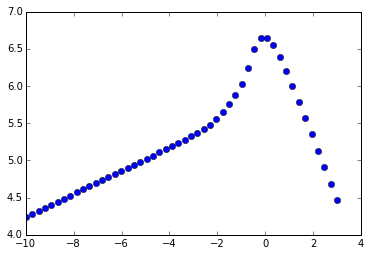

In [96]:
d,v,Ne = read_eleicao("CE","estadual","2014")
#d=np.random.normal(loc=20000.0,scale=500.0,size=2000)  #np.array([2000.0]*1000)
#v=np.array([1.0]*2000)
T_vec=10**np.linspace(-10.,3,50)
mu_vec=[]
v_max_MaxEnt=[]
v_max_Anal=[]
media_preco=[]
condensed_fraction=[]
condensed_fraction1=[]
condensed_fraction_anal=[]
condensed_fraction1_anal=[]

lambida=1.1
for T in T_vec:
    #Nt = Ne*(1-np.exp(-1./T))#np.sum(v)
    #mu,votos_MaxEnt=calcular_usando_MaxEnt(d,v,Ne,Nt,T,"continum")
    #mu_vec.append(abs(mu))
    Ne=lambida*Ne
    d=lambida*d
    d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)
    #hist,bins=np.histogram(np.log10(votos_modelo_analitico[votos_modelo_analitico>0.]),bins=10)
    #x,y=calcular_kde(np.log10(votos_modelo_analitico))
    #max_vote=np.max(votos_MaxEnt)
    v_max_Anal.append(np.max(votos_modelo_analitico))#/np.sum(votos_modelo_analitico))
    
    #condensed_fraction.append(1.*np.sum([x for x in votos_MaxEnt if x==max_vote])/np.sum(votos_MaxEnt))
    #condensed_fraction1.append(1.*len([x for x in votos_MaxEnt if x==max_vote])/len(v))
    
    #condensed_fraction_anal.append(1.*np.sum([x for x in votos_modelo_analitico if x==max_vote_anal])/np.sum(votos_modelo_analitico))
    #condensed_fraction1_anal.append(1.*len([x for x in votos_modelo_analitico if x==max_vote_anal])/len(v))
    

    #plt.plot(x,np.log10(y/10**x),"-")    
    #plt.plot(bins[:-1],hist,"-",label="%s"%T)
    #v_max_MaxEnt.append(np.max(votos_MaxEnt))
    #v_max_Anal.append(np.max(votos_modelo_analitico))
    media_preco.append(np.mean(d_sorted/votos_modelo_analitico)*Ne/np.sum(d))
    
    #print T,mu,Nt/Ne,np.sum(votos_MaxEnt),np.sum(votos_modelo_analitico)
    #print T,T*np.sum(d)/Ne,np.mean(d_sorted/votos_modelo_analitico)*Ne/np.sum(d)#,np.mean(d/votos_MaxEnt)
    
    #plt.plot(np.log10(d),np.log10(votos_MaxEnt/d),"o",label='%s'%T)
    #plt.plot(np.log10(d_sorted),np.log10((votos_modelo_analitico)),"--",label='%s'%T)
    #plt.plot(np.log10(d_sorted),np.log10([1./(T*np.sum(d)/Ne)]*len(d_sorted)),"-",label='%s'%T)

    
#d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,-1./(np.log(1.-1.*np.sum(v)/Ne)))
#print -1./(np.log(1.-1.*np.sum(v)/Ne))
#x,y=calcular_kde(np.log10(votos_modelo_analitico))
#plt.plot(x,y,"g-")    
    
#x,y=calcular_kde(np.log10(d*Ne/np.sum(d)))
#plt.plot(x,y,"r-")  

#x,y=calcular_kde(np.log10(v))
#plt.plot(x,y,"b--")  

#plt.plot(np.log10(T_vec),np.log10(condensed_fraction),"o")
#plt.plot(np.log10(T_vec),np.log10(condensed_fraction1),"ro")

#plt.plot(np.log10(T_vec),np.log10(condensed_fraction_anal),"o-")
#plt.plot(np.log10(T_vec),np.log10(condensed_fraction1_anal),"o--")

plt.plot(np.log10(T_vec),np.log10(v_max_Anal),"o")
#plt.plot(np.log10(T_vec),[1.*Ne/len(d)]*len(T_vec),"o")
print 1.*len(d)/Ne,Ne


#outfile=file("teste.dat","w")
#for i,j in zip(1-np.exp(-T_vec),v_max_Anal):
#    print>>outfile,i,j
#outfile.close()
               
#hist_exper,bins_exper=np.histogram(np.log10(v[v>0.]),bins=10)
#plt.plot(bins_exper[:-1],hist,"--")
#plt.plot(np.log10(T_vec),np.log10(media_preco),"o")
#plt.plot(np.log10(T_vec),np.log10(T_vec),"r-")


#plt.plot(np.log10(T_vec)-np.log10(0.6275),np.log10(v_max_Anal/max(v_max_Anal)),"ro")
#plt.plot(np.log10(T_vec)-np.log10(0.6275),np.log10(v_max_MaxEnt/max(v_max_MaxEnt)),"bo")
#plt.plot(np.log10(T_vec/0.6275),np.log10(mu_vec),"o")
#legend()

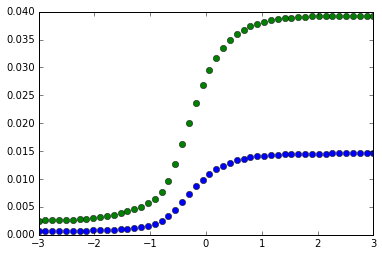

In [78]:
#a=T_vec
#b=v_max_Anal
plt.plot(np.log10(a),b,"o")
plt.plot(np.log10(T_vec),v_max_Anal,"o")


In [ ]:
outfile=file("teste.dat","w")
for i,j in zip(1-np.exp(-T)

7.06732346729 1.0 0.0187237261656


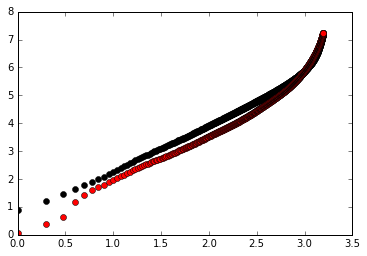

In [61]:
#Anal1=[x for x in np.array(v_max_Anal)/(1.*Ne)]
#MaxEnt2=[x for x  in np.array(v_max_MaxEnt)/(1.*Nt)]

T=1.0#10**1.5

d,v,Ne = read_eleicao("SP","estadual")
Nt = np.sum(v)#Ne*(1-np.exp(-1./T))
mu,votos_MaxEnt=calcular_usando_MaxEnt(d,v,Ne,Nt,-1./(np.log(1.-1.*np.sum(v)/Ne)),"continum")
print T*np.sum(d)/Ne,T,np.max(votos_MaxEnt)/Nt

d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,-1./(np.log(1.-1.*np.sum(v)/Ne)))



#Nt = 100.*Ne*(1-np.exp(-1./T))
#mu,votos_MaxEnt=calcular_usando_MaxEnt(d,v,Ne,T,"discreto")
#print T*np.sum(d)/(100*Ne),T,np.max(votos_MaxEnt)/Nt

#votos_MaxEnt.sort()
v.sort()
#plt.plot(np.log10(range(len(v))),np.log10(np.cumsum(votos_MaxEnt)),"b-")
plt.plot(np.log10(range(len(v))),np.log10(np.cumsum(v)),"ko")
plt.plot(np.log10(range(len(v))),np.log10(np.cumsum(votos_modelo_analitico)),"ro")

#plt.plot(np.log10(d),np.log10(v/d),"ro")
#plt.plot(np.log10(d_sorted),np.log10(votos_modelo_analitico/d_sorted),"ko")
#plt.plot(np.log10(d),np.log10((votos_MaxEnt/d)),"go")

#plt.plot(np.log10(T_vec),np.log10(MaxEnt1),"bo")
#plt.plot(np.log10(T_vec),np.log10(MaxEnt2),"ro")

2906851.38525 2907528.06156


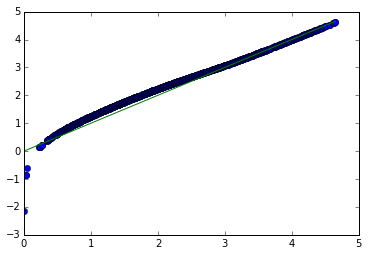

In [63]:
u=zip(d,votos_MaxEnt)
u.sort()
i,j=zip(*u)
plt.plot(np.log10(j),np.log10(votos_modelo_analitico),"o")
plt.plot(np.log10(j),np.log10(j),"-")
print np.sum(j),np.sum(votos_modelo_analitico)

In [24]:
def imprimir(x,y,name):
    outfile=file(name,"w")

    for i,j in zip(x,y):
        print>>outfile,i,j

    outfile.close()

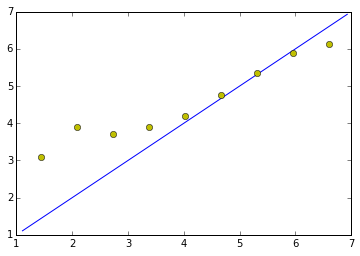

In [68]:
uf="SP"
d,v,Ne = read_eleicao(uf,"federal")
Nt=np.sum(v)
T=-1./(np.log(1.-Nt/Ne))
d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)
x_mean,y_mean,y_std=binagem(d,v,10)

#plt.plot(np.log10(d),np.log10(v),"ro")
#plt.plot(np.log10(d),np.log10(votos_modelo),"ko")
#plt.plot(np.log10(d),np.log10(votos_MaxEnt+400),"go")
delta_m=(T*np.sum(d)/Ne)
#plt.plot(np.log10(d_sorted),np.log10(votos_modelo_analitico*delta_m),"bo")
plt.plot(np.log10(d_sorted),np.log10(d_sorted),"-")
plt.plot(x_mean,np.log10(y_mean*delta_m),"yo")
imprimir(d,v,"teste%sfederal_dados.dat"%uf)
imprimir(10**x_mean,y_mean,"teste%sfederal.dat"%uf)
imprimir(d_sorted,votos_modelo_analitico,"teste%sfederal_model.dat"%uf)

In [105]:
imprimir(T_data,T_calc,"teste.dat")

/home/hygor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/hygor/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:83: RuntimeWarning: Degrees of freedom <= 0 for slice
  warnings.warn("Degrees of freedom <= 0 for slice", RuntimeWarning)


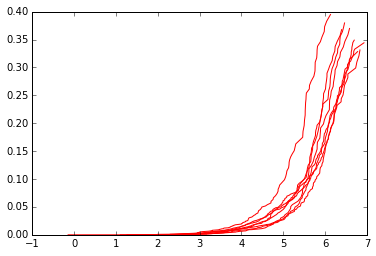

In [20]:
#UFS = ["AC","AL","AM","AP","CE","ES","GO","MA","MS","MT","PA","PB","PI","RN","RO","RR","SC","SE","TO","BA","MG","SP","RJ","RS","PE","PR"]
UFS = ["SP","RJ","MG","RS","BA","PA","PE","CE"]
cargo_array=["federal"]
T_data=[]
T_calc=[]

v_max_data=[]
v_max_calc=[]
v_max_linear=[]


for cargo in cargo_array:
    for uf in UFS:
        
        d,v,Ne = read_eleicao(uf,cargo,"2014")
        Nt=np.sum(v)
        T=-1./(np.log(1.-Nt/Ne))

        if len(v[d<1000.])==0: v0=0.0
        else: v0=np.mean(v[d<1000.])
        Ne0=Ne-len(v)*v0
        
        
        v_max_data.append(np.max(v))
        #v_max_linear.append(np.max(d)/(T*np.sum(d)/Ne))
        
        #T=-1./(np.log((1.*Ne-Nt)/Ne0))
    
        d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)
        
        bins_d,media_v,std_v=binagem(d,v,10)
        #plt.plot(np.log10(media_v),np.log10(std_v),"o")
        #imprimir(media_v,std_v,"teste%s.dat"%uf)
        
        v_max_calc.append(np.max(votos_modelo_analitico))

        T_data.append((1.*Nt)/Ne)
        T_calc.append(np.sum(votos_modelo_analitico)/(1.*Ne))
        
#plt.plot(T_data,T_calc,"o")
#plt.plot(np.linspace(1.0,5.5,2),np.linspace(1.0,5.5,2),"-")
#plt.subplot(2, 1, 1)
#plt.plot(np.log10(d),np.log10(v),"o")
#plt.plot(np.log10(d_sorted),np.log10(votos_modelo_analitico/d_sorted),"-")
        delta_m=T*np.sum(d)/Ne
#plt.plot(np.log10(d_sorted),np.log10((v0+d_sorted/delta_m)/d_sorted),"-")
#plt.subplot(2, 1, 2)
        imprimir(d_sorted,abs(np.cumsum(votos_modelo_analitico)-np.cumsum(v0+d_sorted/delta_m))/np.cumsum(v0+d_sorted/delta_m),"cumulativa_DF_%s.dat"%uf)
        plt.plot(np.log10(d_sorted),abs(np.cumsum(votos_modelo_analitico)-np.cumsum(v0+d_sorted/delta_m))/np.cumsum(v0+d_sorted/delta_m),"r-")

#plt.plot(np.log10(d_sorted),np.log10(np.cumsum(v0+d_sorted/delta_m)),"b-")




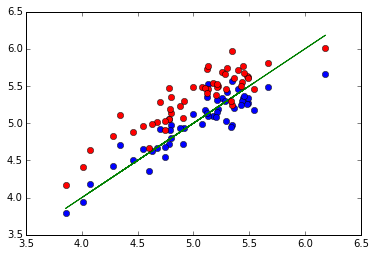

In [100]:
gerar_ruidoso(d,)

plt.plot(np.log10(v_max_data),np.log10(v_max_calc),"o")



In [1]:
def gini(x):
    # (Warning: This is a concise implementation, but it is O(n**2)
    # in time and memory, where n = len(x).  *Don't* pass in huge
    # samples!)

    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

In [37]:
from scipy.stats.stats import pearsonr
#UFS = ["AC","AL","AM","AP","CE","ES","GO","MA","MS","MT","PA","PB","PI","RN","RO","RR","SC","SE","TO","BA","MG","SP","RJ","RS","PE","PR"]
UFS = ["AC","AL","AM","AP","BA","CE","ES","GO","MA","MG","MS","MT","PA","PB","PE","PI","PR","RJ","RN","RO","RR","RS","SC","SE","TO","SP"]
UFS = ["SP"]
cargo_array=["estadual"]#,"federal"]

#x=[]
#y=[]
#nc=[]
for cargo in cargo_array:
    for uf in UFS:
        
        d,v,Ne = read_eleicao(uf,cargo,"2014")
        print len(d)
        r = pearsonr(d,v)
        print len(d)
        print r[0],r[1],np.sum(d),np.sum(v),Ne,np.sum(v)/Ne,uf 
        #if  uf=="RJ": imprimir(v,v,"teste.dat")
        #nc.append(len(v))
        #x.append(np.sum(v)/Ne)
        #y.append(np.std(np.log10(v)))#gini(v))
        #print np.std(v),gini(v),np.sum(v)/Ne,len(v),cargo,uf

#plt.plot(x,nc,"o")

1562
1562
0.721841850596 1.17205546399e-251 226143269.39 17462358.0 31998432 0.545725428046 SP


[-54770.98352915  51068.74192559]


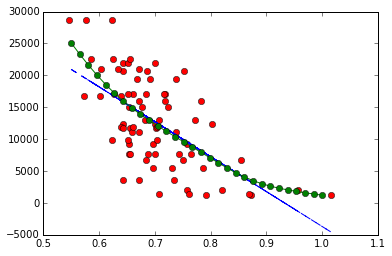

In [138]:
from statsmodels.nonparametric.kernel_regression import KernelReg
kernel=KernelReg(y,x,"c")
y_kernel=kernel.fit(np.linspace(0.55,1.0,30))
par=np.polyfit(x,y,1)
print par
plt.plot(x,y,"ro")
plt.plot(x,np.array(x)*par[0]+par[1],"--")
plt.plot(np.linspace(0.55,1.0,30),y_kernel[0],"-o")
#print y_kernel

In [33]:
UFS = ["ES"]#["AC","AL","AM","AP","CE","ES","GO","MA","MS","MT","PA","PB","PI","RN","RO","RR","SC","SE","TO","BA","MG","SP","RJ","RS","PE","PR"]

cargo_array=["estadual","federal"]
T_data=[]
T_calc=[]

v_max_data=[]
v_max_calc=[]
v_max_linear=[]


for cargo in cargo_array:
    for uf in UFS:
        
        d,v,Ne = read_eleicao(uf,cargo,"2014")
        Nt=np.sum(v)
        T=-1./(np.log(1.-Nt/Ne))
        
        d_sorted,votos_modelo_analitico=calcular_usando_analitico(d,v,Ne,T)
        
        outfile =  file("dados_SI/%s_v0_zero.dat"%(cargo+uf),"w")
        #for i,j in zip(d,v):
        #    print>>outfile, i,j
        #print>>outfile
        for i,j in zip(d_sorted,votos_modelo_analitico):
            print>>outfile, i,j
        outfile.close()
        
    print cargo,uf

estadual ES
federal ES
